## Application of all sites QC mode
We apply the model built from data from all sites. This will have to be run by submission
to the LSF queue at some point.

In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
# Parameters for this run
print_every = 200
expected_class = 4
project_name = "UCD"
pipeline_stable_id = "UCD_001"
procedure_stable_id = "IMPC_XRY_001"
parameter_stable_id = "IMPC_XRY_048_001"
dir_base = "/nfs/komp2/web/images/clean/impc/"
to_process = os.path.join('./images_to_classify/',project_name+"_"+parameter_stable_id+".txt")
processed_output_path = os.path.join('./images_to_classify/',project_name+"_"+parameter_stable_id+"_processed.csv")
mis_classified_output_path = os.path.join('./images_to_classify/',project_name+"_"+parameter_stable_id+"_misclassified.csv")
unable_to_read_output_path = os.path.join('./images_to_classify/',project_name+"_"+parameter_stable_id+"_unable_to_read.csv")

In [3]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()

if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
# Import helper functions
import helper

### Loading and transforming the data
I have a csv file with metadata on the images. All the images are stored in one directory, but I do not want to duplicate them because of space issues. Therefore I cannot use pytorch's ImageFolder class.

I will create a dataset class that can be passed a pandas dataframe with the list of images to be loaded. Dataloaders will then be created from this

In [ ]:
# Create labels using ordered dict. Key is value in "imdetails" value is string we want to display
from collections import OrderedDict
label_map = OrderedDict({1:"head_dorsal",2:"forepaw", 3:"whole_body_dorsal",4:"whole_body_lateral",5:"head_lateral",6:"hind_leg_hip"})

classes = label_map.keys()
n_classes = len(classes)

In [ ]:
# Read in metadata
imdetails = pd.read_csv(to_process)

n_images = len(imdetails)
print(f"Number of images available: {n_images}")

Number of images available: 418


In [ ]:
# Create transforms and dataset
im_size = 224
data_transform = transforms.Compose([ transforms.Lambda(lambda im: helper.crop_to_square(im)),
                                      transforms.Resize(im_size), 
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.48527132, 0.46777139, 0.39808026), (0.26461128, 0.25852081, 0.26486896))])

#dataset = helper.ImageLabelDataset(imdetails, image_dir, data_transform)
dataset = helper.ImageDataset(imdetails, path_column="imagename",
                                  root_dir=None, transform=data_transform)
# define dataloader parameters
batch_size = 10
num_workers=0

### Transforming the Data

When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects `224`-dim square images as input and so, we resize each flower image to fit this mold.

### Data Visualization

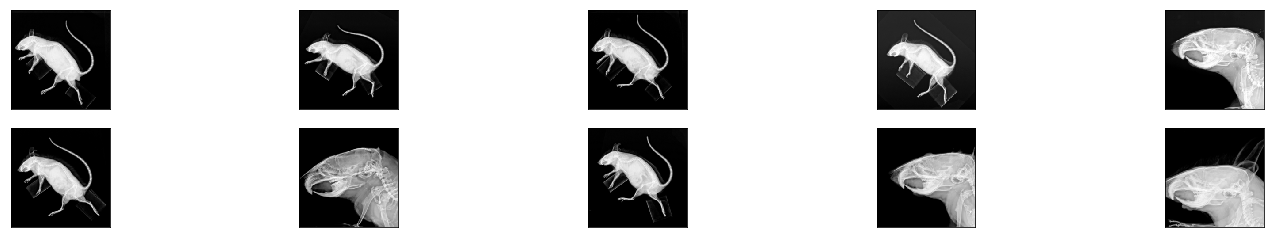

In [ ]:
# Visualize some sample data

# obtain one batch of training images
batch_size = 10
images = []
labels = []
imnames = []
for i in np.arange(batch_size):
    image, imname = dataset[i]
    images.append(image.numpy().copy()) # convert images to numpy for display
    imnames.append(imname)
    
# plot the images in the batch, along with the corresponding labels and whether control or WT
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    im = images[idx]
    imname = imnames[idx].replace('.','\.')
    
    if im.ndim == 3:
        for i in np.arange(3):
            im[i,:,:] -= np.min(im[i,:,:])
            im[i,:,:] /= np.max(im[i,:,:])
    ax = fig.add_subplot(2, np.int((batch_size+1)/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(im, (1, 2, 0)))
    #ax.set_title(classes[labels[idx]]+" ("+biological_sample_group+")")

---
## Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [ ]:
# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.require_grad = False

# Replace last layer for our use case
num_features = model_transfer.classifier[6].in_features
features = list(model_transfer.classifier.children())[:-1]
features.extend([nn.Linear(num_features, n_classes)])
model_transfer.classifier = nn.Sequential(*features)
    
if use_cuda:
    model_transfer = model_transfer.cuda()

# Load our learnt weights
if use_cuda:
    model_transfer = model_transfer.cuda()

model_transfer.load_state_dict(torch.load('./model_transfer.pt'))
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [ ]:
# Get weights of classifier layers
features = list(model_transfer.classifier.children())
print(len(features))
for f in features:
    if isinstance(f, torch.nn.modules.linear.Linear):
        print(f.weight.shape)

7
torch.Size([4096, 25088])
torch.Size([4096, 4096])
torch.Size([6, 4096])


model output [ 0.74050426 -4.9300632  -3.3045256  -0.7201743  11.738193   -1.9974254 ]
prediction: head_lateral


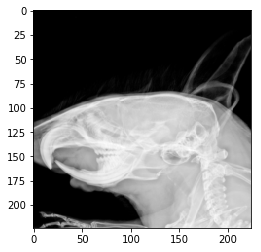

In [ ]:
# Test the model
# Read in an image
try:
    image, im_name = dataset[100]

    # Check that the model classifies it correctly
    model_transfer.eval()

    if use_cuda:
        image = image.cuda()

    output = model_transfer(image.unsqueeze(0))
    output =np.squeeze(output.data.cpu().numpy())
    pred = np.argwhere(output == output.max())[0]+1 # As label_map is 1-based
    print("model output {}".format(output))
    print("prediction: {}".format(label_map[pred[0]]))
    if use_cuda:
        image = image.cpu().numpy()
    plt.imshow(np.transpose(im, (1, 2, 0)))
except Exception as e:
    print("An error occured")
    print(e)

In [ ]:
n_images = len(dataset)
predictions = np.ones([n_images,],np.byte) * -1
mis_classifieds = []
unable_to_read = []

for i in range(n_images):
    try:
        image, imname = dataset[i]
        print(f"Iteration {imname}")
        if use_cuda:
            image = image.cuda()

        output = model_transfer(image.unsqueeze(0))
        output =np.squeeze(output.data.cpu().numpy())
        predictions[i] = np.argwhere(output == output.max())[0]+1
    
        if predictions[i] != expected_class:
            mis_classifieds.append((i,imdetails['imagename'][i],predictions[i]))
        if i%print_every == 0:
            print(f"Iteration {i}")
            print("Number of misclassifieds: {0}".format(len(mis_classifieds)))
    except Exception as e:
        print("An error occured")
        print(e)
        unable_to_read.append(i)
    
    
    

Iteration 0
Iteration 0
Number of misclassifieds: 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45


In [ ]:
# Save the new dataframe
imdetails['classlabel'] = predictions
imdetails.to_csv(processed_output_path, index=False)

In [ ]:
mis_classifieds_df = pd.DataFrame(columns=('index','imagepath','expected','predicted'))

In [ ]:
for i, (index, im_path, predicted) in enumerate(mis_classifieds):
    mis_classifieds_df.loc[i] = [index, im_path, expected_class, predicted]
    

In [ ]:
print(mis_classifieds_df['imagepath'])

In [ ]:
unable_to_read_df = pd.DataFrame(columns=('index','imagepath',))

In [ ]:
for i, ind in enumerate(unable_to_read):
    unable_to_read_df.loc[i] = [ind, imdetails['imagename'][ind]]

In [ ]:
print(unable_to_read_df)

In [ ]:
mis_classifieds_df.to_csv(mis_classified_output_path, index=False)
unable_to_read_df.to_csv(unable_to_read_output_path, index=False)